# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.linear_model import LinearRegression
import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
np.random.seed(42)
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
# общая информация
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В датафрейме всего 16 столбцов и почти 355 тысяч строк, присутствуют пропущенные значения и некорректный тип данных в некоторых столбцах.

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Сразу удалим столбцы, которые, на мой взляд, не несут смысловой нагрузки для  обучения и предсказания модели:
- DateCrawled — дата скачивания анкеты из базы
- RegistrationMonth — месяц регистрации автомобиля - достаточно года регистрации
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя) - нас интересует рынок в целом
- LastSeen — дата последней активности пользователя

Перед удалением признаков проверим данные на дублирующие значения

In [5]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [6]:
# проверка дублирующих значений
print('Количество дубликатов -',df.duplicated(subset = ['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode']).sum())

Количество дубликатов - 10194


In [7]:
# доля дублирующих значений
print('Доля дублирующих значений:', df.duplicated(subset = ['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode']).sum()/df.shape[0])

Доля дублирующих значений: 0.02876662462009939


Доля дублирующих значений составляет 2.8%, удалим их

In [8]:
# удаление дубликатов
df.drop_duplicates(subset = ['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode'], inplace=True)
df = df.reset_index(drop=True)
print('Количество дубликатов после удаления:', df.duplicated().sum())

Количество дубликатов после удаления: 0


In [9]:
# удаление колонок
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
df = df.reset_index(drop=True)

In [10]:
# проверка
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

In [11]:
# описательная статистика
df.describe(include='all')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
count,344175.000000,307223,344175.000000,324726,344175.000000,324754,344175.000000,311729,344175,274247
unique,NaN,8,NaN,2,NaN,250,NaN,7,40,2
top,NaN,sedan,NaN,manual,NaN,golf,NaN,petrol,volkswagen,no
freq,NaN,88618,NaN,260508,NaN,28321,NaN,210087,74667,238920
mean,4395.893249,NaN,2004.223578,NaN,109.904886,NaN,128256.744389,NaN,NaN,NaN
std,4506.888598,NaN,90.906705,NaN,191.468515,NaN,37907.597348,NaN,NaN,NaN
min,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,NaN,NaN,NaN
25%,1000.000000,NaN,1999.000000,NaN,68.000000,NaN,125000.000000,NaN,NaN,NaN
50%,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,NaN,NaN,NaN
75%,6300.000000,NaN,2008.000000,NaN,141.000000,NaN,150000.000000,NaN,NaN,NaN


In [12]:
# функция для построения графика с усами и гистограмму
def graf(param):
    fig, ax = plt.subplots(1, 2, figsize = (18,7))
    df.boxplot(param, ax=ax[0])
    df.hist(param, ax=ax[1], bins=50 )
    plt.tight_layout()

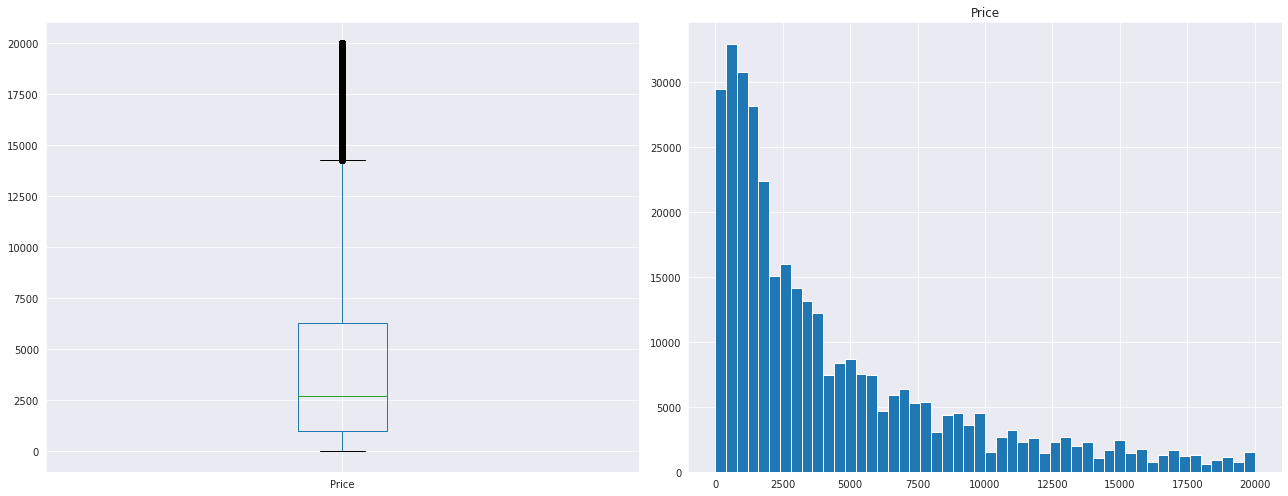

In [13]:
graf(['Price'])

Обратим внимание, что присутствует цена автомобиля равная 0, возможно это имелся в виду обмен. Также присутствует цена менее 30 евро, возможно как и ошибка при заполнении, так и то, что авто тотал, что никак не отображается. Рассмотрим значения меньше 30 евро.

In [14]:
#df[df['Price']<=30]

Таких значений 10 тысяч, возможно это обмен или же машина в тотале и распродают запчасти, удалим эти значения, т.к. это может в дальнейшем помешать модели корректно предсказать цену.

In [15]:
#df=df.query('Price>30')

Удалим значения, где цена равна нулю и рассмотрим подробнее распределение цены

In [16]:
df=df.query('Price!=0')

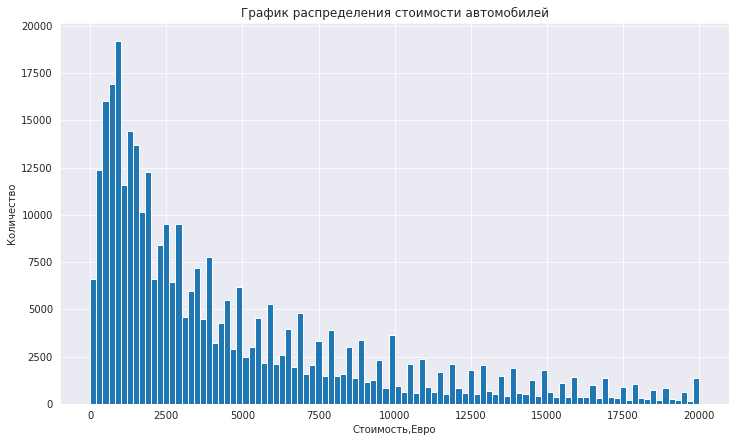

In [17]:
# график распределения цены
df.Price.hist(bins=100, range=(0, 20000), figsize=(12,7))
plt.title('График распределения стоимости автомобилей')
plt.xlabel('Стоимость,Евро')
plt.ylabel('Количество')
plt.show()

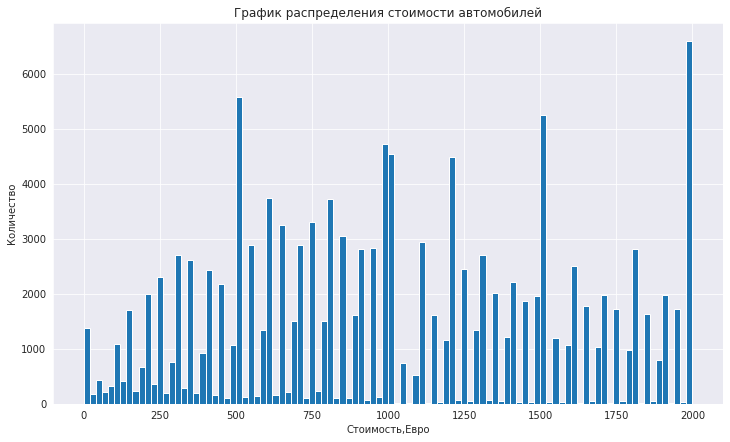

In [18]:
# график распределения цены ближе к левому краю
df.Price.hist(bins=100, range=(0, 2000), figsize=(12,7))
plt.title('График распределения стоимости автомобилей')
plt.xlabel('Стоимость,Евро')
plt.ylabel('Количество')
plt.show()

Поскольку на гисторгамме присутствуют данные возле нуля и длинный хвост около 20 тыс., посмотрим квантили

In [19]:
df['Price'].quantile([.01, 0.99])

0.01      100.0
0.99    18800.0
Name: Price, dtype: float64

In [20]:
#смотрю долю строк, где цена меньше 100 и больше 18850:
(1 - df.query('100 <= Price <= 18850').shape[0] / df.shape[0])*100

1.7422657547220721

In [21]:
#избавляюсь от 1,7% строк, где цена меньше 100 и больше 18850:
df = df.query('100 <= Price <= 18850')

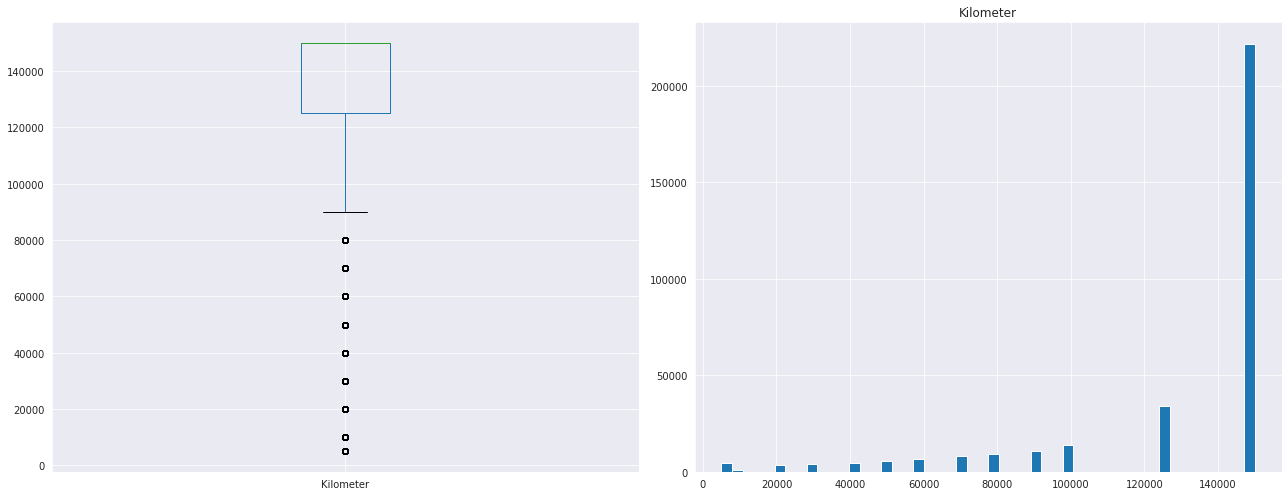

In [22]:
# пробег
graf(['Kilometer'])

По колонке пробег все корректно, пробег варьируется от 5 до 150 тысяч км.

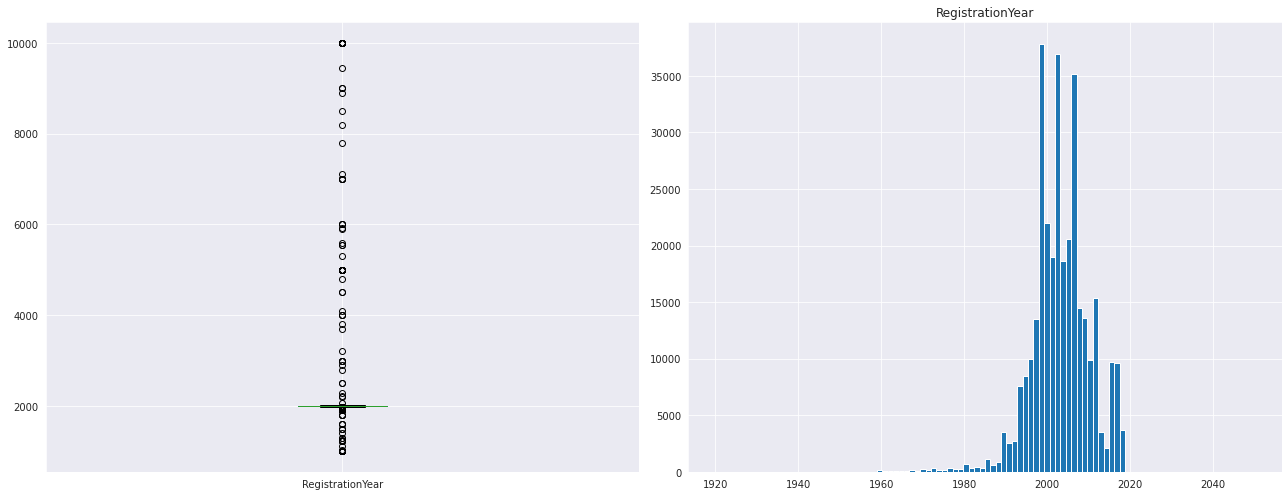

In [23]:
# строим распределение по году регистрации
fig, ax = plt.subplots(1, 2, figsize = (18,7))
df.boxplot('RegistrationYear', ax=ax[0])
df.hist('RegistrationYear', ax=ax[1], bins=100, range=(1920, 2050))
plt.tight_layout()

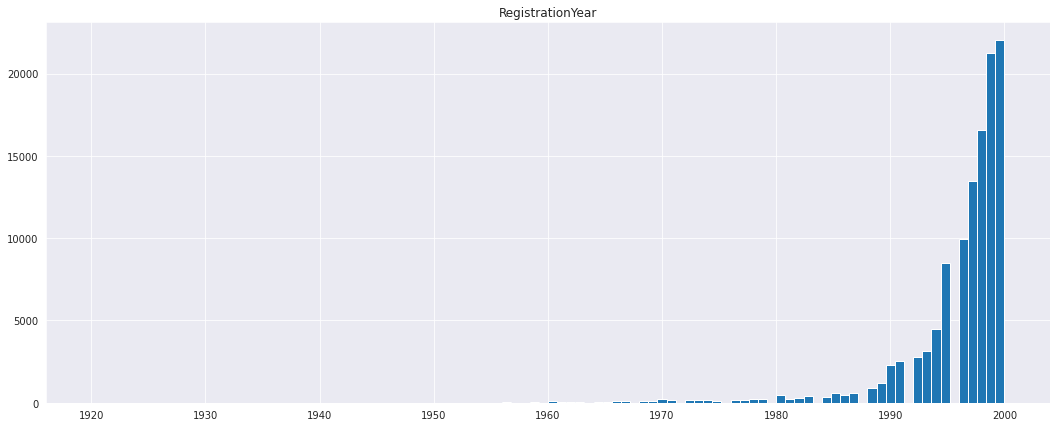

In [24]:
df.hist('RegistrationYear', bins=100, range=(1920, 2000), figsize = (18,7))
plt.show()

По гистограмме заметим, что всплеск регистрации начинается после 1950 года. Посмотрим какое соотношение значений до 1950 к общему числу значений

In [25]:
df.query('RegistrationYear < 1950').shape[0]/df.shape[0]

0.0004239963640024037

В столбце "Год регистрации" присутствует как и 1000 год, так и 9999, такие значения необходимо удалить. Так же удалим авто до 1950 года, потому что это уже ретро авто, если такие авто еще сохранились, то скорее всего они будут продаваться через аукционы.
В столбце присутствует год регистрации больше чем год заполнения анкеты, поэтому удалим данные больше 2017 года

In [26]:
# таких значений меньше 1%, удалим их
df = df.query('2017>RegistrationYear >= 1950')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314295 entries, 0 to 344174
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             314295 non-null  int64 
 1   VehicleType       295693 non-null  object
 2   RegistrationYear  314295 non-null  int64 
 3   Gearbox           300084 non-null  object
 4   Power             314295 non-null  int64 
 5   Model             299503 non-null  object
 6   Kilometer         314295 non-null  int64 
 7   FuelType          291590 non-null  object
 8   Brand             314295 non-null  object
 9   Repaired          257133 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.4+ MB


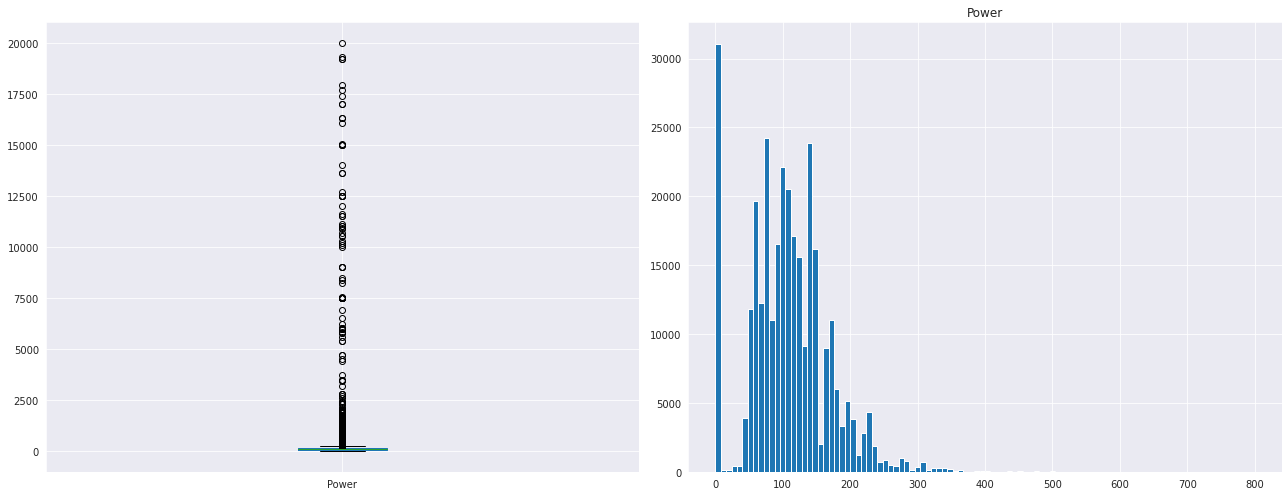

In [28]:
# мощность авто
fig, ax = plt.subplots(1, 2, figsize = (18,7))
df.boxplot('Power', ax=ax[0])
df.hist('Power', ax=ax[1], bins=100, range=(0, 800))
plt.tight_layout()

Погуглив, узнала, что минимальная мощность менее 30 л.с. наблюдается только в раритетных автомобилях, с учетом того, что у нас отбор идет с 1960 гг. такое возможно, но надо рассмотреть подробнее. Также автомобили с мощностью более 1000 л.с. очень редки, это достаточно дорогие суперкары, поэтому их тоже надо рассмотреть и по возможности удалить.

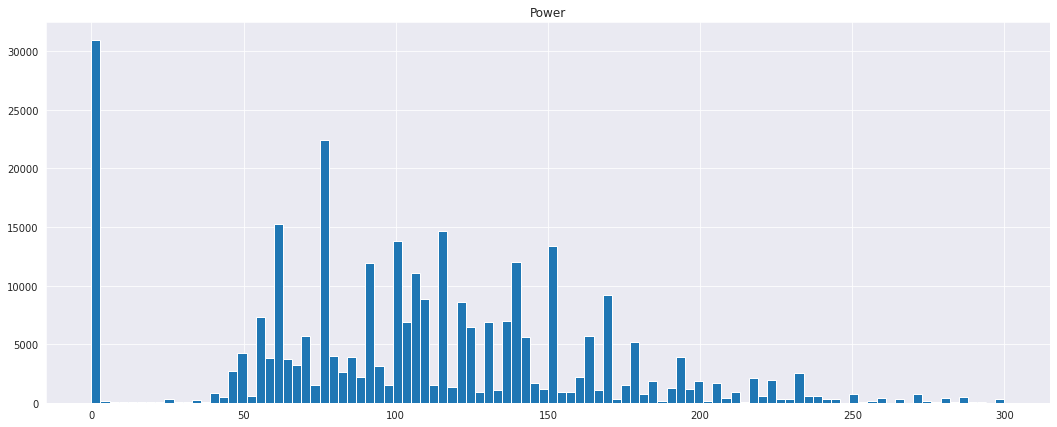

In [29]:
# гистограмма мощности по левому краю
df.hist('Power', figsize = (18,7), bins=100, range=(0, 300))
plt.show()

In [30]:
# рассчитаем в скольких строках мощность равна 0
df.query('Power==0').shape[0]/df.shape[0]

0.09827391463434035

In [31]:
df.query('Power==0').shape[0]

30887

Таких значений почти 10 процентов, восстановим значения этого признака, взяв самое частое значение по параметрам модель / брэнд.

In [32]:
# нули заменим на пропущенное значение
df[df['Power'] == 0] = np.nan

In [33]:
# меняем на медианк
df['Power'] = df['Power'].combine_first(df.groupby(['Brand', 'Model'])['Power'].transform('median'))

In [34]:
# описательная статистика
df['Power'].describe()

count    283408.000000
mean        123.521852
std         193.578264
min           1.000000
25%          75.000000
50%         110.000000
75%         150.000000
max       20000.000000
Name: Power, dtype: float64

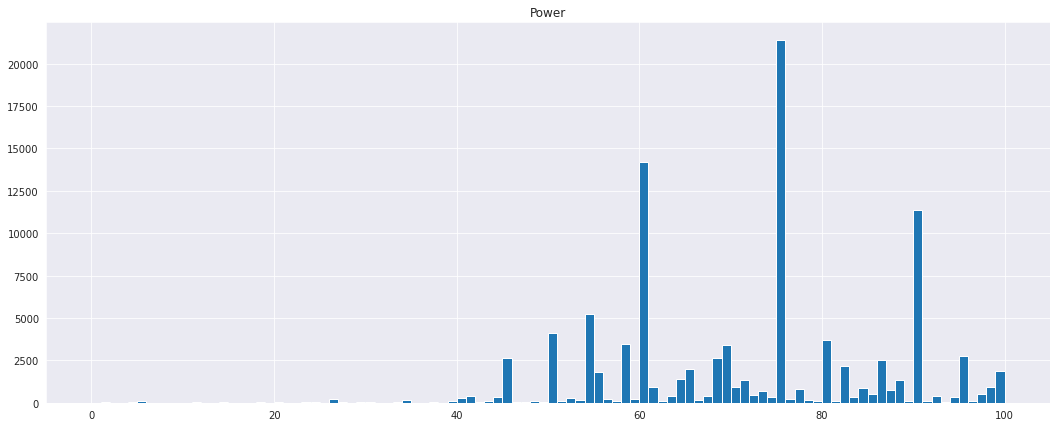

In [35]:
df.hist('Power', figsize = (18,7), bins=100, range=(0, 100))
plt.show()

In [36]:
df.query('1000>=Power<40').shape[0]/df.shape[0]

0.003958064875355955

In [37]:
# удалим значения более 1000 и значения менее 40
df = df.query('1000>Power>40')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281618 entries, 1 to 344174
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             281618 non-null  float64
 1   VehicleType       271052 non-null  object 
 2   RegistrationYear  281618 non-null  float64
 3   Gearbox           276545 non-null  object 
 4   Power             281618 non-null  float64
 5   Model             271116 non-null  object 
 6   Kilometer         281618 non-null  float64
 7   FuelType          266668 non-null  object 
 8   Brand             281618 non-null  object 
 9   Repaired          240311 non-null  object 
dtypes: float64(4), object(6)
memory usage: 23.6+ MB


Далее рассмотрим категориальные признаки и пропуски в них

In [38]:
# соотношение пропущенных значений
df.isna().mean().sort_values(ascending=False)

Repaired            0.146677
FuelType            0.053086
VehicleType         0.037519
Model               0.037292
Gearbox             0.018014
Price               0.000000
RegistrationYear    0.000000
Power               0.000000
Kilometer           0.000000
Brand               0.000000
dtype: float64

Отметим, что больше всего пропусков в столбце Repaired (была машина в ремонте или нет). это может быть связано как с тем, что пользователь не сообщил о факте отсутствия ремонта, либо автомобиль подвергался ремонту, данные отсутствуют в зависимости от неизвестных факторов. Вероятность пропуска могла бы быть описана на основе других атрибутов, но информация по этим атрибутам в наборе данных отсутствует, аналогично vehicle_type. Поэтому заменим в эти
fuel_type, gearbox, model - достаточно важные признаки, наблюдается 2-6% пропусков - тип топлива, коробка передач и модель автомобиля влияют на конечную цену. Могли появится по причине пропуска данных характеристик при заполнении объявления пользователем - умышленно либо по причине неосведомленности

In [39]:
df['VehicleType'].value_counts()


sedan          79137
small          66625
wagon          56540
bus            25062
convertible    17587
coupe          13688
suv            10082
other           2331
Name: VehicleType, dtype: int64

In [40]:
df['Repaired'].value_counts()

no     212586
yes     27725
Name: Repaired, dtype: int64

In [41]:
df['FuelType'].value_counts()

petrol      178493
gasoline     82953
lpg           4476
cng            470
hybrid         188
other           53
electric        35
Name: FuelType, dtype: int64

In [42]:
df['Model'].value_counts()

golf                  23661
other                 19211
3er                   16581
polo                  10226
corsa                  9603
                      ...  
kalina                    4
serie_3                   3
rangerover                2
601                       2
range_rover_evoque        1
Name: Model, Length: 249, dtype: int64

In [43]:
df['Gearbox'].value_counts()

manual    221540
auto       55005
Name: Gearbox, dtype: int64

In [44]:
nan_cols = ['Repaired', 'VehicleType', 'FuelType', 'Gearbox', 'Model']
df[nan_cols] = df[nan_cols].fillna('unknown')

Проверим данные и посмотрим корреляцию между ними

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281618 entries, 1 to 344174
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             281618 non-null  float64
 1   VehicleType       281618 non-null  object 
 2   RegistrationYear  281618 non-null  float64
 3   Gearbox           281618 non-null  object 
 4   Power             281618 non-null  float64
 5   Model             281618 non-null  object 
 6   Kilometer         281618 non-null  float64
 7   FuelType          281618 non-null  object 
 8   Brand             281618 non-null  object 
 9   Repaired          281618 non-null  object 
dtypes: float64(4), object(6)
memory usage: 23.6+ MB


In [46]:
df.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.497856,0.489627,-0.378507
RegistrationYear,0.497856,1.000000,0.110210,-0.308243
Power,0.489627,0.110210,1.000000,0.109182
Kilometer,-0.378507,-0.308243,0.109182,1.000000


Наблюдается средняя положительная связь между ценой автомобиля и годом регистрации, а также средняя отрицательная между пробегом и ценой, что логично, чем больше пробег, тем цена за автомобиль ниже. 

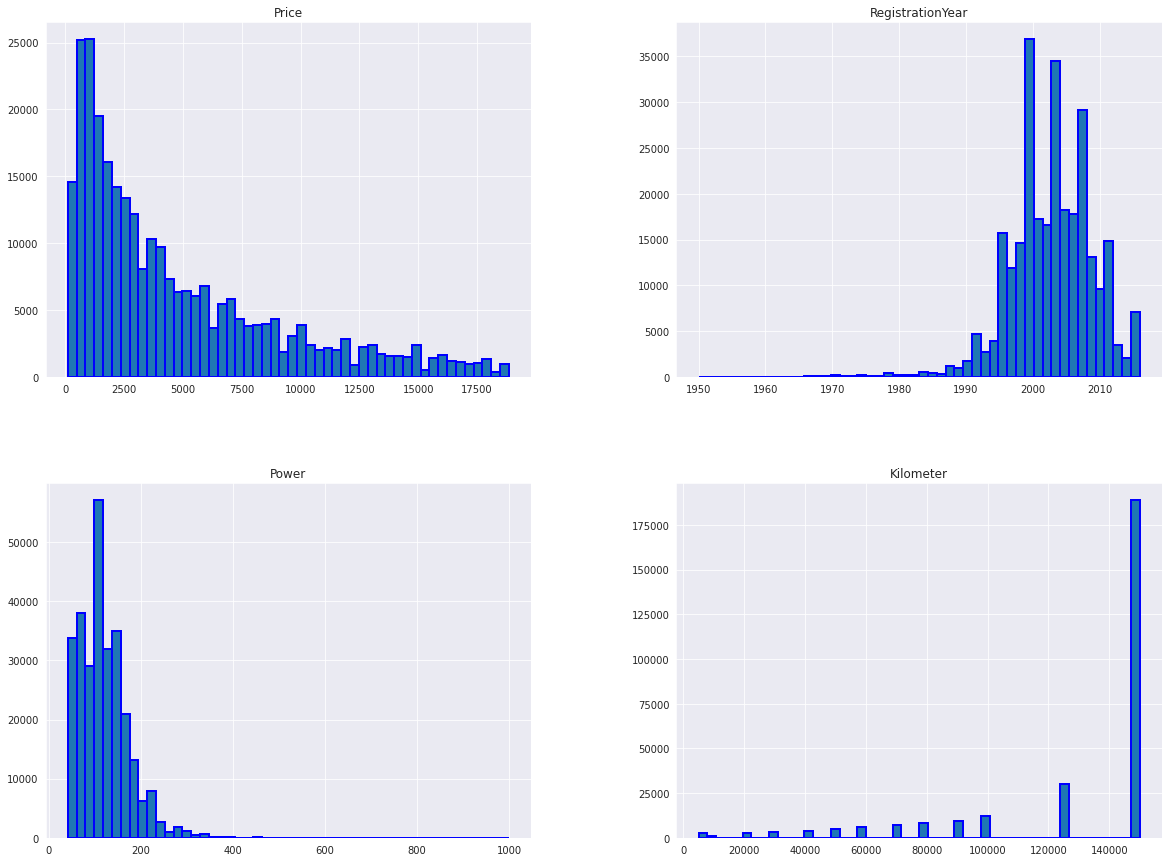

In [47]:
# проверка распределения
df.hist(bins=50, figsize=(20,15), edgecolor='blue', linewidth=2)
plt.show()

**ВЫВОД:**
Данные для дальнейшего обучения подготовлены. Были удалены признаки, которые не несут полезной нагрузки для дальнейшего обучения модели. На этапе исследования были выявлены аномалии, дубликаты, пропуски:
 - дубликаты были удалены;
 - пропущенные значения заменены на unknown;
 - аномалии удалены

На этапе предобработки были удалены 64 тыс. строк, что составляет 16% от общей выборки.

## Обучение моделей

Обучение моделей будем проводить с помощью библиотек Catboost, LightGBM, LinearRegression и RandomForestRegressor. Для оценки качества моделей будем применять метрику RMSE.

In [48]:
# разделим выборки на целевой признак и остальные признаки
features=df.drop(['Price'],axis=1)
target=df['Price']

In [49]:
# разделим на обучающую и тестовую выборки
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.25, random_state=12345)

In [50]:
print(train_features.shape)
print(test_features.shape)
print(train_target.shape)
print(test_target.shape)

(211213, 9)
(70405, 9)
(211213,)
(70405,)


In [51]:
folds = KFold(n_splits=4,  shuffle=True, random_state=12345)

### Catboost

Catboost умеет работать с категориальными переменными - в кодировании нет необходимости. Составим список наших категорий

In [52]:
cat_features = list(train_features.select_dtypes(include=['object']).columns)
cat_features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [53]:
# функция для подсчета лучших гиперпараметров

model = CatBoostRegressor()
params = {'learning_rate': [0.03, 0.25],
            'n_estimators' : [50, 100],
            'verbose' : [0],
            'random_state' : [12345],
            'max_depth' : [5, 10, 12]
    }
grid_cv = GridSearchCV(estimator=model, 
                           param_grid=params, 
                           n_jobs=-1,
                           scoring='neg_mean_squared_error', 
                           cv=folds)
grid_cv.fit(train_features, train_target, cat_features=cat_features, verbose=20)
rmse_gr_cat = (-grid_cv.best_score_) ** 0.5
print('Best hyperparams: ', grid_cv.best_params_)
print('RMSE score on train sample: {:.2f}'.format(rmse_gr_cat))

0:	learn: 4290.8981226	total: 110ms	remaining: 5.4s
20:	learn: 3127.3662139	total: 1.1s	remaining: 1.52s
40:	learn: 2551.4191741	total: 2.02s	remaining: 444ms
49:	learn: 2387.1783702	total: 2.48s	remaining: 0us
0:	learn: 4280.7669757	total: 53.9ms	remaining: 2.64s
20:	learn: 3119.8898847	total: 1.02s	remaining: 1.41s
40:	learn: 2540.3766718	total: 1.94s	remaining: 427ms
49:	learn: 2381.5942387	total: 2.35s	remaining: 0us
0:	learn: 4277.0956842	total: 56.2ms	remaining: 2.75s
20:	learn: 3113.0856687	total: 1.08s	remaining: 1.49s
40:	learn: 2538.0535708	total: 2.06s	remaining: 452ms
49:	learn: 2381.1919205	total: 2.46s	remaining: 0us
0:	learn: 4285.2389785	total: 52.6ms	remaining: 2.58s
20:	learn: 3121.1958585	total: 1.01s	remaining: 1.4s
40:	learn: 2545.6626552	total: 1.98s	remaining: 435ms
49:	learn: 2380.5153446	total: 2.44s	remaining: 0us
0:	learn: 4290.8981226	total: 55.4ms	remaining: 5.49s
20:	learn: 3127.3662139	total: 999ms	remaining: 3.76s
40:	learn: 2551.4191741	total: 1.92s	rem

In [54]:
rmse_gr_cat

1505.5516689236376

In [55]:
# обучение модели по лучшим гиперпараметрам
start = time.time()
model_cat = CatBoostRegressor(iterations=100, learning_rate=0.25, 
                              verbose=20, cat_features=cat_features, random_seed=12345, 
                              max_depth=12)
model_cat.fit(train_features, train_target)
end = time.time()
t_cat_f=round(end-start,2)

0:	learn: 3591.3384213	total: 200ms	remaining: 19.8s
20:	learn: 1566.2531336	total: 3.74s	remaining: 14.1s
40:	learn: 1476.8558426	total: 7.22s	remaining: 10.4s
60:	learn: 1416.4212832	total: 10.9s	remaining: 6.96s
80:	learn: 1378.2440911	total: 14.4s	remaining: 3.37s
99:	learn: 1350.3540630	total: 17.7s	remaining: 0us


In [56]:
# предсказание

start = time.time()
predict_cat=model_cat.predict(test_features)
end = time.time()
t_cat_p=round(end-start,2)

In [57]:
rmse_cat = mean_squared_error(test_target, predict_cat) ** 0.5
print(f'RMSE модели на базе библиотеки Catboost: {round(rmse_cat, 4)}')

RMSE модели на базе библиотеки Catboost: 1494.6047


In [1]:
# рассчитаем важность параметров
importances_cat = model_cat.feature_importances_
feat=features_test.columns
indices = np.argsort(importances_cat)
plt.figure(figsize=(11, 5))
plt.title('Важность параметра')
plt.barh(range(len(indices)), importances_cat[indices], color='#6495ED', align='center')
plt.yticks(range(len(indices)), feat[indices])
plt.show()

NameError: name 'model_cat' is not defined

Как видно на графике для модели самый важный признак - это год регистрации автомобиля, не менее важные - мощность, бренд и тип кузова

### LightGBM

LightGBM также умеет работать с категориальными переменными, нет необходимости применять кодирование, но нам необходимо привести категориальные признаки к типу category.

In [59]:
gbm_features = list(train_features.columns)
gbm_features

['VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Model',
 'Kilometer',
 'FuelType',
 'Brand',
 'Repaired']

In [60]:
train_features_gbm = train_features.copy()
for cat in cat_features:
    train_features_gbm[cat] = train_features_gbm[cat].astype('category')
train_features_gbm.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211213 entries, 292478 to 265669
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       211213 non-null  category
 1   RegistrationYear  211213 non-null  float64 
 2   Gearbox           211213 non-null  category
 3   Power             211213 non-null  float64 
 4   Model             211213 non-null  category
 5   Kilometer         211213 non-null  float64 
 6   FuelType          211213 non-null  category
 7   Brand             211213 non-null  category
 8   Repaired          211213 non-null  category
dtypes: category(6), float64(3)
memory usage: 7.9 MB


In [61]:
test_features_gbm = test_features.copy()
for cat in cat_features:
    test_features_gbm[cat] = test_features_gbm[cat].astype('category')
test_features_gbm.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70405 entries, 219613 to 111122
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   VehicleType       70405 non-null  category
 1   RegistrationYear  70405 non-null  float64 
 2   Gearbox           70405 non-null  category
 3   Power             70405 non-null  float64 
 4   Model             70405 non-null  category
 5   Kilometer         70405 non-null  float64 
 6   FuelType          70405 non-null  category
 7   Brand             70405 non-null  category
 8   Repaired          70405 non-null  category
dtypes: category(6), float64(3)
memory usage: 2.6 MB


In [62]:
# подбор гиперпараметров
model_gmb = lgb.LGBMRegressor(objective='regression', 
                        random_state=101)
params_gmb = {
      'learning_rate': [0.1, 0.25],
      #'n_estimators': [50, 100, 150],
      'n_estimators': [50, 100],
      'max_depth': [5, 7, 10],
      #'colsample_bytree': [0.7, 0.8, 0.9],
      #'subsample': [0.7, 0.8, 0.9],
      #'min_child_samples': [1, 5, 10]
  }
grid_cv_gmb = GridSearchCV(estimator=model_gmb, 
                       param_grid=params_gmb,
                       cv=folds, 
                       n_jobs=-1, 
                       scoring='neg_root_mean_squared_error')
#grid_cv_gmb.fit(train_features_gbm, train_target)
grid_cv_gmb.fit(train_features_gbm, train_target, categorical_feature = cat_features)
rmse_cv_gmb = (grid_cv_gmb.best_score_)
print('Best hyperparams: ', grid_cv_gmb.best_params_)
#print('RMSE score on train sample: {:.2f}'.format((-grid_cv_gmb.best_score_) ** 0.5))

Best hyperparams:  {'learning_rate': 0.25, 'max_depth': 10, 'n_estimators': 100}
RMSE score on train sample: 38.85


In [63]:
rmse_gr_gbm = abs(grid_cv_gmb.best_score_)
rmse_gr_gbm

1509.07306330896

In [64]:
# обучение модели
%time
start_gbm = time.time()

model_lgb = LGBMRegressor(random_state=12345, max_depth=10, n_estimators=100, learning_rate=0.1)
model_lgb.fit(train_features_gbm, train_target, 
              eval_set=(test_features_gbm, test_target), 
              verbose=10, 
              eval_metric='rmse')
end_gbm = time.time()
t_gbm_f = end_gbm - start_gbm

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
[10]	valid_0's rmse: 2406.11	valid_0's l2: 5.78938e+06
[20]	valid_0's rmse: 1839.9	valid_0's l2: 3.38524e+06
[30]	valid_0's rmse: 1670.04	valid_0's l2: 2.78904e+06
[40]	valid_0's rmse: 1608.51	valid_0's l2: 2.58732e+06
[50]	valid_0's rmse: 1579.15	valid_0's l2: 2.49371e+06
[60]	valid_0's rmse: 1560.29	valid_0's l2: 2.43451e+06
[70]	valid_0's rmse: 1547.86	valid_0's l2: 2.39587e+06
[80]	valid_0's rmse: 1539.94	valid_0's l2: 2.37141e+06
[90]	valid_0's rmse: 1532.99	valid_0's l2: 2.35007e+06
[100]	valid_0's rmse: 1528.2	valid_0's l2: 2.33541e+06


In [65]:
# предсказание модели
start_gbm_p = time.time()

pred_gbmp = model_lgb.predict(test_features_gbm)
rmse_gbm = mean_squared_error(test_target, pred_gbmp) ** 0.5

end_gbm_p = time.time()
t_gbm_p = end_gbm_p - start_gbm_p
print(f'RMSE модели на базе библиотеки LGBM {round(rmse_gbm, 4)}')

RMSE модели на базе библиотеки LGBM 1528.2034


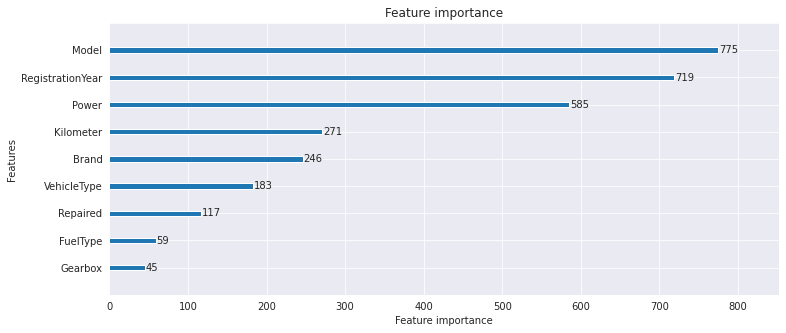

In [66]:
lgb.plot_importance(model_lgb, figsize = (12, 5))
plt.show()

Для LightGBM самый важный признак - это мощность, а уже потом год регистрации, модель, пробег и бренд.

### LinearRegression

Для построения линейной регрессии необходимо OHE кодирование категориальных признаков, а также провести стандартизацию количественных

In [67]:
#кодирую признаки через OHE:
features_ohe = pd.get_dummies(features, drop_first=True)

features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe,
                                                                                            target,
                                                                                            test_size=.25,
                                                                                            random_state=12345)

In [68]:
%%time
start_f = time.time()
model_lr=LinearRegression()
scores_line = cross_val_score(model_lr,  
                                          features_train_ohe, 
                                          target_train_ohe, 
                                          scoring = 'neg_root_mean_squared_error',
                                          cv = folds)
model_lr.fit(features_train_ohe,target_train_ohe)
end_f = time.time()
t_lr_f = round(end_f-start_f, 2)

CPU times: user 54.9 s, sys: 24.5 s, total: 1min 19s
Wall time: 1min 20s


In [69]:
scores_line

array([-2441.84050695, -2456.66283605, -2464.44806817, -2453.63404069])

In [70]:
rmse_gr_lr = (np.mean(abs(scores_line)))
rmse_gr_lr

2454.146362966825

In [71]:
%%time
start_p = time.time()
predict_lr=model_lr.predict(features_test_ohe)
end_p = time.time()
t_lr_p=round(end_p-start_p, 2)

CPU times: user 70.2 ms, sys: 71.3 ms, total: 142 ms
Wall time: 253 ms


In [72]:
rmse_lr = ((mean_squared_error(target_test_ohe, predict_lr))**0.5).round(2)
print('RMSE модели Линейная Регрессия равна:', rmse_lr)

RMSE модели Линейная Регрессия равна: 2432.48


### RandomForestRegressor

In [76]:
# Модель и параметры
mod_rf = RandomForestRegressor(random_state=12345)
params_rf = {'max_depth': [x for x in range(1, 16, 5)],
            'n_estimators': [x for x in range(1, 100, 50)],
            'n_jobs' : [-1]
            }

In [77]:
%%time
grid_rf_r = GridSearchCV(mod_rf, 
                         params_rf, 
                         scoring='neg_mean_squared_error', 
                         cv=folds)
grid_rf_r.fit(features_train_ohe,target_train_ohe)
rmse_gr_rf = grid_rf_r.best_score_
# Выводим лучшие параметры
print(grid_rf_r.best_params_)

{'max_depth': 11, 'n_estimators': 51, 'n_jobs': -1}
CPU times: user 15min 28s, sys: 6.74 s, total: 15min 35s
Wall time: 15min 37s


In [78]:
rmse_gr_rf = (abs(grid_rf_r.best_score_))**0.5

In [96]:
%%time
start_f = time.time()
model_rf = RandomForestRegressor(random_state=12345, criterion='mse',warm_start=False, n_estimators=51, max_depth=11)
model_rf.fit(features_train_ohe, target_train_ohe)
end_f = time.time()
t_rf_f=round(end_f-start_f,2)

CPU times: user 2min 46s, sys: 775 ms, total: 2min 46s
Wall time: 2min 47s


In [97]:
%%time
start_p = time.time()
pred_rf=model_rf.predict(features_test_ohe)
end_p = time.time()
t_rf_p=round(end_p-start_p,2)

CPU times: user 439 ms, sys: 79.2 ms, total: 518 ms
Wall time: 526 ms


In [98]:
rmse_rf = ((mean_squared_error(target_test_ohe, pred_rf))**0.5).round(2)
print('RMSE модели Случайный лес равна:', rmse_rf)

RMSE модели Случайный лес равна: 1739.14


## Анализ моделей

Проанализируем скорость работы и качество моделей.
Для наглядности сведём все интересующие нас даные в таблицу

In [99]:
column=['RMSE модели','Скорость обучения, s','Скорость предсказания, s']

comparison_tabl = pd.DataFrame(index=['RMSE модели','RMSE на кросс-валидации', 'Скорость обучения, s', 'Скорость предсказания, s'], columns=['CatBoostRegressor','LightGBM', 'LinearRegression','RandomForestRegressor'])
comparison_tabl['LinearRegression'] = rmse_lr, rmse_gr_lr, t_lr_f, t_lr_p
comparison_tabl['RandomForestRegressor'] = rmse_rf,rmse_gr_rf,  t_rf_f, t_rf_p
comparison_tabl['CatBoostRegressor'] = rmse_cat, rmse_gr_cat, t_cat_f, t_cat_p
comparison_tabl['LightGBM'] = rmse_gbm, rmse_gr_gbm,t_gbm_f,t_gbm_p

comparison_tabl.T.style.highlight_min(color='yellowgreen',subset=column).highlight_null(null_color='lightgrey').highlight_max(color='coral',subset=column)

,RMSE модели,RMSE на кросс-валидации,"Скорость обучения, s","Скорость предсказания, s"
CatBoostRegressor,1494.604684,1505.551669,18.590000,0.120000
LightGBM,1528.203374,1509.073063,6.089528,0.700434
LinearRegression,2432.480000,2454.146363,80.100000,0.250000
RandomForestRegressor,1739.140000,1732.391038,167.610000,0.530000


Практически все модели на тестовой выборки показали незначительно лучший результат (менее 2%)ю Самый лучший результат по предсказаниям  и по времени обучения показала  модель CatBoostRegressor, на втором месте LightGBM, но по времени обучения намного хуже всех моделей. Попробуем удалить изначально пропущенные значения и проверить как ведут себя модели

In [83]:
# колонки с пропущенными значениями
nan_cols

['Repaired', 'VehicleType', 'FuelType', 'Gearbox', 'Model']

In [84]:
# для обучающей выборки
train_features_new = train_features[(train_features['Repaired'] != 'unknown') & (train_features['VehicleType'] != 'unknown')  & \
        (train_features['FuelType'] != 'unknown') & (train_features['Gearbox'] != 'unknown') & \
        (train_features['Model'] != 'unknown')]
train_features_new.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
325278,wagon,2010.0,manual,160.0,insignia,100000.0,gasoline,opel,no
289699,bus,2001.0,manual,82.0,sprinter,150000.0,gasoline,mercedes_benz,no
196349,sedan,1996.0,manual,122.0,c_klasse,150000.0,petrol,mercedes_benz,no
71647,wagon,2006.0,manual,155.0,mondeo,150000.0,gasoline,ford,no
291155,small,2009.0,manual,60.0,corsa,70000.0,petrol,opel,no


In [85]:
# для тестовой выборки
test_features_new = test_features[(test_features['Repaired'] != 'unknown') & (test_features['VehicleType'] != 'unknown')  & \
        (test_features['FuelType'] != 'unknown') & (test_features['Gearbox'] != 'unknown') & \
        (test_features['Model'] != 'unknown')]
test_features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
219613,bus,2011.0,manual,116.0,other,150000.0,gasoline,hyundai,no
9304,sedan,2002.0,manual,136.0,3_reihe,150000.0,petrol,peugeot,yes
40826,sedan,1998.0,manual,90.0,mondeo,150000.0,unknown,ford,no
238139,wagon,2007.0,manual,150.0,5_reihe,150000.0,gasoline,mazda,no
4804,sedan,1995.0,manual,90.0,impreza,150000.0,petrol,subaru,no


In [86]:
train_features_new.shape, test_features_new.shape

((165648, 9), (55115, 9))

In [87]:
# приводим в порядок целевой признак
train_target_new = train_target[train_target.index.isin(train_features_new.index)]
test_target_new = test_target[test_target.index.isin(test_features_new.index)]
train_target_new.shape, test_target_new.shape

((165648,), (55115,))

**Catboost после корректировки**

In [88]:
# обучение модели

start_cat_new = time.time()
model_cat_new = CatBoostRegressor(iterations=100, learning_rate=0.25, 
                              verbose=20, cat_features=cat_features, random_seed=42, max_depth=12)
model_cat_new.fit(train_features_new, train_target_new, eval_set=(test_features_new,test_target_new))
end_cat_new = time.time()
t_cat_f_new=round(end_cat_new-start_cat_new, 2)

0:	learn: 3654.3376496	test: 3655.0091214	best: 3655.0091214 (0)	total: 144ms	remaining: 14.2s
20:	learn: 1555.9269892	test: 1598.0258826	best: 1598.0258826 (20)	total: 2.65s	remaining: 9.98s
40:	learn: 1466.6657593	test: 1528.9550677	best: 1528.9550677 (40)	total: 5.11s	remaining: 7.35s
60:	learn: 1416.9452916	test: 1504.6186054	best: 1504.6186054 (60)	total: 7.63s	remaining: 4.88s
80:	learn: 1379.5902208	test: 1487.1813722	best: 1487.1813722 (80)	total: 10.1s	remaining: 2.36s
99:	learn: 1354.2153244	test: 1478.6831181	best: 1478.6831181 (99)	total: 12.4s	remaining: 0us

bestTest = 1478.683118
bestIteration = 99



In [89]:
# предсказание

start = time.time()
predict_cat_new=model_cat_new.predict(test_features_new)
end = time.time()
t_cat_p_new=round(end-start,2)
rmse_cat_new = mean_squared_error(test_target_new, predict_cat_new) ** 0.5
print(f'RMSE модели на базе библиотеки Catboost после корректировки: {round(rmse_cat_new, 4)}')

RMSE модели на базе библиотеки Catboost после корректировки: 1478.6831


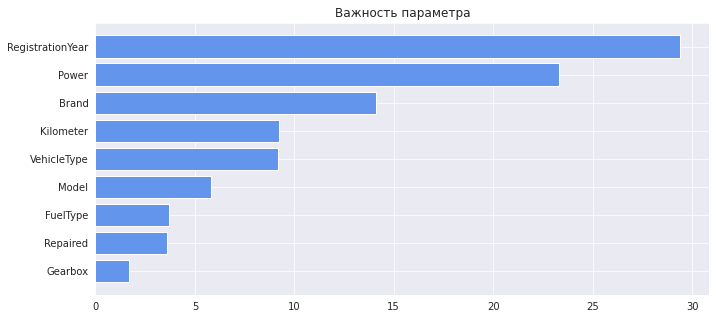

In [90]:
# рассчитаем важность параметров
importances_cat_new = model_cat_new.feature_importances_
feat=features.columns
indices = np.argsort(importances_cat_new)
plt.figure(figsize=(11, 5))
plt.title('Важность параметра')
plt.barh(range(len(indices)), importances_cat_new[indices], color='#6495ED', align='center')
plt.yticks(range(len(indices)), feat[indices])
plt.show()

**LightGBM после корректировки**

In [91]:
train_features_new_gbm = train_features_new.copy()
for cat in cat_features:
    train_features_new_gbm[cat] = train_features_new_gbm[cat].astype('category')
train_features_new_gbm.dtypes

VehicleType         category
RegistrationYear     float64
Gearbox             category
Power                float64
Model               category
Kilometer            float64
FuelType            category
Brand               category
Repaired            category
dtype: object

In [92]:
test_features_new_gbm = test_features_new.copy()
for cat in cat_features:
    test_features_new_gbm[cat] = test_features_new_gbm[cat].astype('category')
test_features_new_gbm.dtypes

VehicleType         category
RegistrationYear     float64
Gearbox             category
Power                float64
Model               category
Kilometer            float64
FuelType            category
Brand               category
Repaired            category
dtype: object

In [93]:
# обучение модели
%time
start_gbm_new = time.time()

model_lgb_new = LGBMRegressor(random_state=12345, max_depth=10, n_estimators=100, learning_rate=0.1)
model_lgb_new.fit(train_features_new_gbm, train_target_new, 
              eval_set=(test_features_new_gbm, test_target_new), 
              verbose=10, 
              eval_metric='rmse')
end_gbm_new = time.time()
t_gbm_f_new = end_gbm - start_gbm


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
[10]	valid_0's rmse: 2414.58	valid_0's l2: 5.83021e+06
[20]	valid_0's rmse: 1820.88	valid_0's l2: 3.31561e+06
[30]	valid_0's rmse: 1651.18	valid_0's l2: 2.7264e+06
[40]	valid_0's rmse: 1590.15	valid_0's l2: 2.52857e+06
[50]	valid_0's rmse: 1558.83	valid_0's l2: 2.42994e+06
[60]	valid_0's rmse: 1541.22	valid_0's l2: 2.37537e+06
[70]	valid_0's rmse: 1529.5	valid_0's l2: 2.33937e+06
[80]	valid_0's rmse: 1520.76	valid_0's l2: 2.31272e+06
[90]	valid_0's rmse: 1513.79	valid_0's l2: 2.29156e+06
[100]	valid_0's rmse: 1508.75	valid_0's l2: 2.27634e+06


In [94]:
%%time
start_gbm_p_new = time.time()



pred_gbmp_new = model_lgb_new.predict(test_features_new_gbm)
rmse_gbm_new = mean_squared_error(test_target_new, pred_gbmp_new) ** 0.5

end_gbm_p_new = time.time()
t_gbm_p_new = end_gbm_p_new - start_gbm_p_new
print(f'RMSE модели на базе библиотеки LGBM после корректировки: {round(rmse_gbm_new, 4)}')

RMSE модели на базе библиотеки LGBM после корректировки: 1508.7536
CPU times: user 533 ms, sys: 5.29 ms, total: 539 ms
Wall time: 507 ms


In [95]:
column=['RMSE модели','Скорость обучения, s','Скорость предсказания, s']

comparison_tabl = pd.DataFrame(index=['RMSE модели', 'Скорость обучения, s', 'Скорость предсказания, s'], columns=['CatBoostRegressor','LightGBM', 'LinearRegression','RandomForestRegressor'])
comparison_tabl['LinearRegression'] = rmse_lr, t_lr_f, t_lr_p
comparison_tabl['RandomForestRegressor'] = rmse_rf,  t_rf_f, t_rf_p
comparison_tabl['CatBoostRegressor'] = rmse_cat, t_cat_f, t_cat_p
comparison_tabl['LightGBM'] = rmse_gbm,t_gbm_f,t_gbm_p
comparison_tabl['CatBoostRegressor_new'] = rmse_cat_new, t_cat_f_new, t_cat_p_new
comparison_tabl['LightGBM_new'] = rmse_gbm_new, t_gbm_f_new, t_gbm_p_new
comparison_tabl.T.style.highlight_min(color='yellowgreen',subset=column).highlight_null(null_color='lightgrey').highlight_max(color='coral',subset=column)

,RMSE модели,"Скорость обучения, s","Скорость предсказания, s"
CatBoostRegressor,1494.604684,18.590000,0.120000
LightGBM,1528.203374,6.089528,0.700434
LinearRegression,2432.480000,80.100000,0.250000
RandomForestRegressor,2113.310000,96.120000,0.260000
CatBoostRegressor_new,1478.683118,13.640000,0.090000
LightGBM_new,1508.753551,6.089528,0.505930


После удаления пропущенных значений качество моделей изменилось не сильно. С небольшим отрывом лучшая модель стала LightGBM, при этом CatBoostRegressor выигрывает по времени обучения и предсказания.

## Общий вывод

Перед нами стояла задача - построить модель для определения стоимости автомобиля, с лучшими показателями качества предсказания, скорости и времени обучения. В нашем распоряжении были исторические данные: технические характеристики, комплектации и цены автомобилей.

При предобработки данных были удалены дубликаты, проанализированы и исправлены аномалии, а также удалены признаки, которые не влияют на обучение модели.

Для изучения модели использовались технологию градиетного бустинга в моделях CatBoostRegressor и LightGBM, и сравнили её с базовыми моделями LinearRegression и RandomForestRegressor

По итогам качества на тестовых данных - с небольшим отрывом модель LightGBM показывает лучшие результаты предсказаний, но уступает по скорости обучения и предсказания перед CatBoostRegressor.

Таким образом, для компании "Не бит, не крашен" можем  рекомендовать модель CatBoostRegressor, т.к. можно немного поступиться по качеству модели в пользу достижения скорости обучения и предсказания на новых данных при сохранении приблизительно тех же показателей по качеству предсказания.
